# Comprehensive CryoET Zarr Benchmark

## Overview

This notebook provides a complete workflow for:
- 📥 Downloading real cryo-EM data from CryoET portal
- 📊 3D visualization with Napari and Vizarr
- 🔬 Comprehensive benchmarking based on HEFTIE project
- ✅ Image quality validation (SSIM, PSNR, MSE)
- 📈 Performance analysis and recommendations

## HEFTIE Benchmark Configurations

Based on https://heftieproject.github.io/zarr-benchmarks/

**Tested:**
- Codecs: Blosc-Zstd, Blosc-LZ4, Blosc-Zlib, Zstd, GZip, No Compression
- Shuffle: shuffle, bitshuffle, noshuffle
- Compression levels: 1, 3, 5, 7, 9
- Chunk sizes: 64, 128, 256

**HEFTIE Recommendations:**
- Level 3 is optimal baseline
- Chunk size > 90 for best performance
- Blosc-Zstd with shuffle for image data
- Zstd for dense segmentation

⚠️ **IMPORTANT**: Select kernel **"Python 3.13 (zarr-benchmarks)"** before running!

In [13]:
# Verify environment
import sys

print(f"Python: {sys.version}")
print(f"Executable: {sys.executable}")
if "3.13" in sys.version and "venv" in sys.executable:
    print("✓ Correct environment!")
else:
    print("⚠️  Please select 'Python 3.13 (zarr-benchmarks)' kernel")

Python: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]
Executable: /Users/mkothari/zarr-benchmarks/venv/bin/python
✓ Correct environment!


In [14]:
# Import libraries
import pathlib
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import zarr
from cryoet_data_portal import Client, Dataset
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from zarr_benchmarks import utils
from zarr_benchmarks.read_write_zarr import read_write_zarr

warnings.filterwarnings("ignore")

print("✓ All imports successful")

✓ All imports successful


## Configuration

Set your benchmark parameters here:

In [15]:
# Download size (max 512 recommended)
DOWNLOAD_SIZE = 256  # Start smaller, increase to 512 if you want

# Quick test or comprehensive?
QUICK_MODE = True  # Set False for full HEFTIE benchmark suite

if QUICK_MODE:
    # Quick test: fewer configurations
    CODECS = ["blosc_zstd", "blosc_lz4", "zstd", "no_compression"]
    SHUFFLES = ["shuffle"]  # Only test shuffle
    LEVELS = [3, 5]  # Test HEFTIE baseline (3) and mid-high (5)
    CHUNKS = [128]  # Single chunk size
else:
    # Full HEFTIE suite
    CODECS = ["blosc_zstd", "blosc_lz4", "blosc_zlib", "zstd", "gzip", "no_compression"]
    SHUFFLES = ["shuffle", "bitshuffle", "noshuffle"]
    LEVELS = [1, 3, 5, 7, 9]
    CHUNKS = [64, 128, 256]

ZARR_SPEC = 2  # Use v2 for vizarr compatibility

print("Configuration:")
print(
    f"  Download size: {DOWNLOAD_SIZE}³ = {(DOWNLOAD_SIZE**3 * 4) / (1024**2):.1f} MB"
)
print(f"  Mode: {'Quick' if QUICK_MODE else 'Comprehensive'}")
print(f"  Codecs: {len(CODECS)}")
print(f"  Tests: ~{len(CODECS) * len(LEVELS) * len(CHUNKS)} configurations")

Configuration:
  Download size: 256³ = 64.0 MB
  Mode: Quick
  Codecs: 4
  Tests: ~8 configurations


## 1. Connect to CryoET Portal & Download Data

In [16]:
print("Connecting to CryoET Data Portal...")
client = Client()
dataset = Dataset.get_by_id(client, 10445)

print(f"✓ Dataset: {dataset.title}")
print(f"  ID: {dataset.id}")

Connecting to CryoET Data Portal...
✓ Dataset: CZII - CryoET Object Identification Challenge - Public Test Dataset
  ID: 10445


In [17]:
# Find a tomogram large enough
print(f"\nFinding tomogram >= {DOWNLOAD_SIZE}³...")

runs = list(dataset.runs)
selected_tomo = None
selected_run = None

for run in runs:
    tomograms = list(run.tomograms)
    for tomo in tomograms:
        if (
            tomo.size_x >= DOWNLOAD_SIZE
            and tomo.size_y >= DOWNLOAD_SIZE
            and tomo.size_z >= DOWNLOAD_SIZE
        ):
            selected_tomo = tomo
            selected_run = run
            break
    if selected_tomo:
        break

if not selected_tomo:
    print("⚠️  Using largest available tomogram")
    max_vol = 0
    for run in runs:
        for tomo in list(run.tomograms):
            vol = tomo.size_x * tomo.size_y * tomo.size_z
            if vol > max_vol:
                max_vol = vol
                selected_tomo = tomo
                selected_run = run

print(f"✓ Selected: {selected_tomo.name}")
print(
    f"  Size: {selected_tomo.size_x} × {selected_tomo.size_y} × {selected_tomo.size_z}"
)
print(f"  Voxel spacing: {selected_tomo.voxel_spacing} Å")
print(f"  Run: {selected_run.name}")


Finding tomogram >= 256³...
✓ Selected: TS_100_3
  Size: 1260 × 1260 × 368
  Voxel spacing: 4.99 Å
  Run: TS_100_3


In [18]:
# Access S3 data
print("\nAccessing zarr data from S3...")

s3 = s3fs.S3FileSystem(anon=True)
zarr_path = selected_tomo.s3_omezarr_dir.replace("s3://", "")
store = s3fs.S3Map(root=zarr_path, s3=s3, check=False)
zarr_group = zarr.open(store, mode="r")
zarr_array = zarr_group["0"]  # Full resolution

print(f"✓ Zarr shape: {zarr_array.shape}")
print(f"  Dtype: {zarr_array.dtype}")
print(f"  Chunks: {zarr_array.chunks}")
print("  Compressor: Blosc-LZ4 (original)")


Accessing zarr data from S3...
✓ Zarr shape: (368, 1260, 1260)
  Dtype: float32
  Chunks: (256, 256, 256)
  Compressor: Blosc-LZ4 (original)


In [19]:
# Download centered cube
actual_size = min(DOWNLOAD_SIZE, min(zarr_array.shape))

z_c = zarr_array.shape[0] // 2
y_c = zarr_array.shape[1] // 2
x_c = zarr_array.shape[2] // 2

z_start = max(0, z_c - actual_size // 2)
z_end = min(zarr_array.shape[0], z_start + actual_size)
y_start = max(0, y_c - actual_size // 2)
y_end = min(zarr_array.shape[1], y_start + actual_size)
x_start = max(0, x_c - actual_size // 2)
x_end = min(zarr_array.shape[2], x_start + actual_size)

print(f"\nDownloading {actual_size}³ cube from center...")
print(f"Region: Z[{z_start}:{z_end}], Y[{y_start}:{y_end}], X[{x_start}:{x_end}]")

start_time = time.time()
reference_data = np.array(zarr_array[z_start:z_end, y_start:y_end, x_start:x_end])
download_time = time.time() - start_time

print(f"✓ Downloaded in {download_time:.2f}s")
print(f"  Shape: {reference_data.shape}")
print(f"  Size: {reference_data.nbytes / (1024**2):.2f} MB")
print(f"  Range: [{reference_data.min():.3f}, {reference_data.max():.3f}]")
print(f"  Mean: {reference_data.mean():.3f} ± {reference_data.std():.3f}")


Region: Z[56:312], Y[502:758], X[502:758]
✓ Downloaded in 64.94s
  Shape: (256, 256, 256)
  Size: 64.00 MB
  Range: [-0.000, 0.000]
  Mean: -0.000 ± 0.000


## 2. Visualize Data (2D Slices)

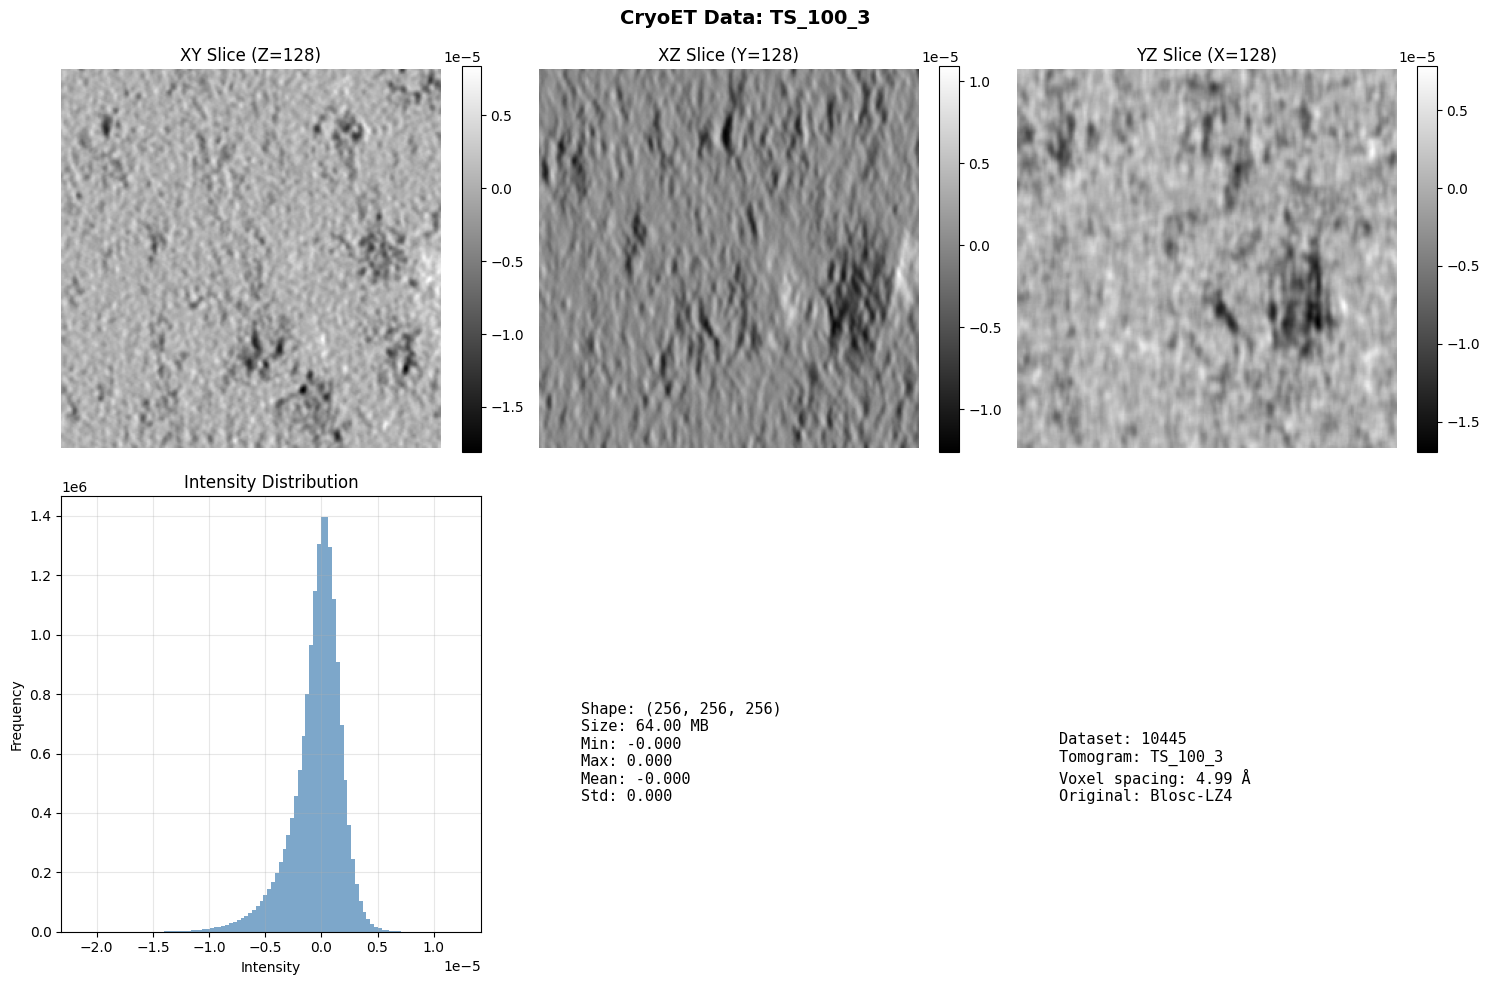

✓ 2D visualization complete


In [20]:
# Create slice visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle(f"CryoET Data: {selected_tomo.name}", fontsize=14, fontweight="bold")

mid_z = reference_data.shape[0] // 2
mid_y = reference_data.shape[1] // 2
mid_x = reference_data.shape[2] // 2

# Three orthogonal slices
im1 = axes[0, 0].imshow(reference_data[mid_z, :, :], cmap="gray")
axes[0, 0].set_title(f"XY Slice (Z={mid_z})")
axes[0, 0].axis("off")
plt.colorbar(im1, ax=axes[0, 0], fraction=0.046)

im2 = axes[0, 1].imshow(reference_data[:, mid_y, :], cmap="gray")
axes[0, 1].set_title(f"XZ Slice (Y={mid_y})")
axes[0, 1].axis("off")
plt.colorbar(im2, ax=axes[0, 1], fraction=0.046)

im3 = axes[0, 2].imshow(reference_data[:, :, mid_x], cmap="gray")
axes[0, 2].set_title(f"YZ Slice (X={mid_x})")
axes[0, 2].axis("off")
plt.colorbar(im3, ax=axes[0, 2], fraction=0.046)

# Histogram
axes[1, 0].hist(reference_data.flatten(), bins=100, color="steelblue", alpha=0.7)
axes[1, 0].set_title("Intensity Distribution")
axes[1, 0].set_xlabel("Intensity")
axes[1, 0].set_ylabel("Frequency")
axes[1, 0].grid(True, alpha=0.3)

# Statistics
stats_text = f"""Shape: {reference_data.shape}
Size: {reference_data.nbytes / (1024**2):.2f} MB
Min: {reference_data.min():.3f}
Max: {reference_data.max():.3f}
Mean: {reference_data.mean():.3f}
Std: {reference_data.std():.3f}"""
axes[1, 1].text(0.1, 0.3, stats_text, fontsize=11, family="monospace")
axes[1, 1].axis("off")

# Dataset info
info_text = f"""Dataset: {dataset.id}
Tomogram: {selected_tomo.name}
Voxel spacing: {selected_tomo.voxel_spacing} Å
Original: Blosc-LZ4"""
axes[1, 2].text(0.1, 0.3, info_text, fontsize=11, family="monospace")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

print("✓ 2D visualization complete")

## 3. 3D Visualization with Napari

**Run this cell to open an interactive 3D viewer:**

In [ ]:
# Optional: 3D visualization with napari
# Uncomment to use (opens separate window)

# import napari
# viewer = napari.view_image(
#     reference_data,
#     name=f'{selected_tomo.name}',
#     colormap='gray',
#     contrast_limits=[reference_data.min(), reference_data.max()]
# )
# napari.run()

print("💡 Uncomment the code above to view in 3D with napari")
print("   (Opens separate window for interactive exploration)")

## 4. Run Comprehensive Benchmarks

This tests multiple compression configurations based on HEFTIE recommendations.

In [ ]:
# Setup output directory
output_dir = pathlib.Path("data/output/comprehensive_benchmark")
output_dir.mkdir(parents=True, exist_ok=True)

# Store results
all_results = []

print(f"Starting {'quick' if QUICK_MODE else 'comprehensive'} benchmark...\n")

In [ ]:
# Helper function for image quality metrics
def calculate_metrics(original, compressed):
    """Calculate SSIM, PSNR, MSE"""
    try:
        # Normalize for SSIM
        orig_norm = (original - original.min()) / (
            original.max() - original.min() + 1e-10
        )
        comp_norm = (compressed - compressed.min()) / (
            compressed.max() - compressed.min() + 1e-10
        )

        # Middle slice for SSIM (faster)
        mid = original.shape[0] // 2
        ssim_val = ssim(orig_norm[mid], comp_norm[mid], data_range=1.0)

        # Full volume for PSNR/MSE
        data_range = original.max() - original.min()
        psnr_val = psnr(original, compressed, data_range=data_range)
        mse_val = mse(original, compressed)

        return ssim_val, psnr_val, mse_val
    except Exception as e:
        print(f"   Warning: Metrics failed - {e}")
        return None, None, None


print("✓ Metric function ready")

In [ ]:
# Test configurations
test_num = 0

for codec in CODECS:
    print(f"\n{'=' * 60}")
    print(f"Testing: {codec.upper()}")
    print(f"{'=' * 60}")

    if codec == "no_compression":
        # No compression: test chunk sizes only
        for chunk_size in CHUNKS:
            test_num += 1
            print(f"[{test_num}] chunk={chunk_size}...", end=" ")

            store_path = output_dir / f"{codec}_c{chunk_size}.zarr"
            utils.remove_output_dir(store_path)

            chunks = (chunk_size, chunk_size, chunk_size)

            t0 = time.time()
            read_write_zarr.write_zarr_array(
                reference_data,
                store_path,
                overwrite=False,
                chunks=chunks,
                compressor=None,
                zarr_spec=ZARR_SPEC,
            )
            write_time = time.time() - t0

            t0 = time.time()
            read_back = read_write_zarr.read_zarr_array(store_path)
            read_time = time.time() - t0

            ratio = 1.0
            size_mb = utils.get_directory_size(store_path) / (1024**2)
            ssim_val, psnr_val, mse_val = calculate_metrics(reference_data, read_back)

            all_results.append(
                {
                    "codec": codec,
                    "shuffle": "N/A",
                    "level": 0,
                    "chunk_size": chunk_size,
                    "write_time": write_time,
                    "read_time": read_time,
                    "ratio": ratio,
                    "size_mb": size_mb,
                    "ssim": ssim_val,
                    "psnr": psnr_val,
                    "mse": mse_val,
                }
            )

            print(f"W:{write_time:.3f}s R:{read_time:.3f}s Size:{size_mb:.1f}MB")

    elif "blosc" in codec:
        # Blosc variants: test shuffle + levels + chunks
        cname = codec.split("_")[1]  # zstd, lz4, or zlib

        for shuffle in SHUFFLES:
            for level in LEVELS:
                for chunk_size in CHUNKS:
                    test_num += 1
                    print(
                        f"[{test_num}] {shuffle[:4]}, L{level}, c{chunk_size}...",
                        end=" ",
                    )

                    store_path = (
                        output_dir / f"{codec}_{shuffle}_l{level}_c{chunk_size}.zarr"
                    )
                    utils.remove_output_dir(store_path)

                    chunks = (chunk_size, chunk_size, chunk_size)
                    compressor = read_write_zarr.get_blosc_compressor(
                        cname, level, shuffle
                    )

                    t0 = time.time()
                    read_write_zarr.write_zarr_array(
                        reference_data,
                        store_path,
                        overwrite=False,
                        chunks=chunks,
                        compressor=compressor,
                        zarr_spec=ZARR_SPEC,
                    )
                    write_time = time.time() - t0

                    t0 = time.time()
                    read_back = read_write_zarr.read_zarr_array(store_path)
                    read_time = time.time() - t0

                    ratio = read_write_zarr.get_compression_ratio(store_path)
                    size_mb = utils.get_directory_size(store_path) / (1024**2)
                    ssim_val, psnr_val, mse_val = calculate_metrics(
                        reference_data, read_back
                    )

                    all_results.append(
                        {
                            "codec": codec,
                            "shuffle": shuffle,
                            "level": level,
                            "chunk_size": chunk_size,
                            "write_time": write_time,
                            "read_time": read_time,
                            "ratio": ratio,
                            "size_mb": size_mb,
                            "ssim": ssim_val,
                            "psnr": psnr_val,
                            "mse": mse_val,
                        }
                    )

                    ssim_str = f"{ssim_val:.4f}" if ssim_val is not None else "N/A"
                    print(
                        f"W:{write_time:.3f}s R:{read_time:.3f}s {ratio:.2f}x SSIM:{ssim_str}"
                    )

    else:
        # Other codecs: test levels + chunks
        for level in LEVELS:
            for chunk_size in CHUNKS:
                test_num += 1
                print(f"[{test_num}] L{level}, c{chunk_size}...", end=" ")

                store_path = output_dir / f"{codec}_l{level}_c{chunk_size}.zarr"
                utils.remove_output_dir(store_path)

                chunks = (chunk_size, chunk_size, chunk_size)

                if codec == "zstd":
                    compressor = read_write_zarr.get_zstd_compressor(level)
                else:  # gzip
                    compressor = read_write_zarr.get_gzip_compressor(level)

                t0 = time.time()
                read_write_zarr.write_zarr_array(
                    reference_data,
                    store_path,
                    overwrite=False,
                    chunks=chunks,
                    compressor=compressor,
                    zarr_spec=ZARR_SPEC,
                )
                write_time = time.time() - t0

                t0 = time.time()
                read_back = read_write_zarr.read_zarr_array(store_path)
                read_time = time.time() - t0

                ratio = read_write_zarr.get_compression_ratio(store_path)
                size_mb = utils.get_directory_size(store_path) / (1024**2)
                ssim_val, psnr_val, mse_val = calculate_metrics(
                    reference_data, read_back
                )

                all_results.append(
                    {
                        "codec": codec,
                        "shuffle": "N/A",
                        "level": level,
                        "chunk_size": chunk_size,
                        "write_time": write_time,
                        "read_time": read_time,
                        "ratio": ratio,
                        "size_mb": size_mb,
                        "ssim": ssim_val,
                        "psnr": psnr_val,
                        "mse": mse_val,
                    }
                )

                ssim_str = f"{ssim_val:.4f}" if ssim_val is not None else "N/A"
                print(
                    f"W:{write_time:.3f}s R:{read_time:.3f}s {ratio:.2f}x SSIM:{ssim_str}"
                )

print(f"\n✓ Completed {len(all_results)} benchmark tests")

## 5. Analyze Results

In [ ]:
# Create DataFrame
df = pd.DataFrame(all_results)

# Save to CSV
csv_path = output_dir / f"benchmark_results_{DOWNLOAD_SIZE}cube.csv"
df.to_csv(csv_path, index=False)
print(f"✓ Saved results to: {csv_path}")

# Display summary
print(f"\nTotal configurations tested: {len(df)}")
print(f"Data size: {reference_data.nbytes / (1024**2):.2f} MB")
df.head(10)

In [ ]:
# Summary statistics
print("=" * 70)
print("BENCHMARK SUMMARY")
print("=" * 70)

print("\n1. Best Overall Performance:")
print(
    f"   Fastest write: {df.loc[df['write_time'].idxmin(), 'codec']:20s} {df['write_time'].min():.3f}s"
)
print(
    f"   Fastest read:  {df.loc[df['read_time'].idxmin(), 'codec']:20s} {df['read_time'].min():.3f}s"
)
print(
    f"   Best compression: {df.loc[df['ratio'].idxmax(), 'codec']:17s} {df['ratio'].max():.2f}x"
)
print(
    f"   Best SSIM:     {df.loc[df['ssim'].idxmax(), 'codec']:20s} {df['ssim'].max():.6f}"
)
print(
    f"   Best PSNR:     {df.loc[df['psnr'].idxmax(), 'codec']:20s} {df['psnr'].max():.2f} dB"
)

print("\n2. HEFTIE Recommended (level=3, shuffle, chunk>=90):")
heftie = df[
    (df["level"] == 3)
    & (df["shuffle"].isin(["shuffle", "N/A"]))
    & (df["chunk_size"] >= 90)
]
if not heftie.empty:
    best = heftie.loc[heftie["ratio"].idxmax()]
    print(f"   Codec: {best['codec']}")
    print(f"   Compression: {best['ratio']:.2f}x")
    print(f"   Write: {best['write_time']:.3f}s, Read: {best['read_time']:.3f}s")
    print(f"   SSIM: {best['ssim']:.6f}, PSNR: {best['psnr']:.2f} dB")

print("\n3. Comparison by Codec (level=5, chunk=128, shuffle where applicable):")
for codec in CODECS:
    if codec == "no_compression":
        subset = df[(df["codec"] == codec) & (df["chunk_size"] == 128)]
    elif "blosc" in codec:
        subset = df[
            (df["codec"] == codec)
            & (df["level"] == 5)
            & (df["chunk_size"] == 128)
            & (df["shuffle"] == "shuffle")
        ]
    else:
        subset = df[
            (df["codec"] == codec) & (df["level"] == 5) & (df["chunk_size"] == 128)
        ]

    if not subset.empty:
        row = subset.iloc[0]
        ssim_str = f"{row['ssim']:.4f}" if row["ssim"] is not None else "N/A"
        print(
            f"   {codec:20s}: {row['ratio']:4.2f}x  W:{row['write_time']:5.3f}s  "
            f"R:{row['read_time']:5.3f}s  SSIM:{ssim_str:>6s}"
        )

## 6. Visualization of Results

In [ ]:
# Plot comparison (level=5, chunk=128)
plot_df = df[
    (df["level"].isin([0, 5]))
    & (df["chunk_size"] == 128)
    & (df["shuffle"].isin(["shuffle", "N/A"]))
].copy()

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle(
    "Compression Benchmark Results (Level 5, Chunk 128, Shuffle)",
    fontsize=14,
    fontweight="bold",
)

# Write time
axes[0, 0].bar(range(len(plot_df)), plot_df["write_time"], color="steelblue")
axes[0, 0].set_xticks(range(len(plot_df)))
axes[0, 0].set_xticklabels(plot_df["codec"], rotation=45, ha="right")
axes[0, 0].set_ylabel("Time (s)")
axes[0, 0].set_title("Write Performance")
axes[0, 0].grid(True, alpha=0.3)

# Read time
axes[0, 1].bar(range(len(plot_df)), plot_df["read_time"], color="coral")
axes[0, 1].set_xticks(range(len(plot_df)))
axes[0, 1].set_xticklabels(plot_df["codec"], rotation=45, ha="right")
axes[0, 1].set_ylabel("Time (s)")
axes[0, 1].set_title("Read Performance")
axes[0, 1].grid(True, alpha=0.3)

# Compression ratio
axes[0, 2].bar(range(len(plot_df)), plot_df["ratio"], color="green")
axes[0, 2].set_xticks(range(len(plot_df)))
axes[0, 2].set_xticklabels(plot_df["codec"], rotation=45, ha="right")
axes[0, 2].set_ylabel("Ratio")
axes[0, 2].set_title("Compression Ratio")
axes[0, 2].grid(True, alpha=0.3)

# Storage size
axes[1, 0].bar(range(len(plot_df)), plot_df["size_mb"], color="purple")
axes[1, 0].set_xticks(range(len(plot_df)))
axes[1, 0].set_xticklabels(plot_df["codec"], rotation=45, ha="right")
axes[1, 0].set_ylabel("Size (MB)")
axes[1, 0].set_title("Storage Size")
axes[1, 0].grid(True, alpha=0.3)

# SSIM
axes[1, 1].bar(range(len(plot_df)), plot_df["ssim"], color="orange")
axes[1, 1].set_xticks(range(len(plot_df)))
axes[1, 1].set_xticklabels(plot_df["codec"], rotation=45, ha="right")
axes[1, 1].set_ylabel("SSIM")
axes[1, 1].set_title("Structural Similarity (Higher=Better)")
axes[1, 1].set_ylim([plot_df["ssim"].min() * 0.9999, 1.0001])
axes[1, 1].grid(True, alpha=0.3)

# PSNR
axes[1, 2].bar(range(len(plot_df)), plot_df["psnr"], color="brown")
axes[1, 2].set_xticks(range(len(plot_df)))
axes[1, 2].set_xticklabels(plot_df["codec"], rotation=45, ha="right")
axes[1, 2].set_ylabel("PSNR (dB)")
axes[1, 2].set_title("Peak Signal-to-Noise Ratio")
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    output_dir / f"benchmark_comparison_{DOWNLOAD_SIZE}cube.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print("✓ Comparison plots generated")

## 7. Compression Level Analysis

In [ ]:
# Analyze compression levels for blosc_zstd (HEFTIE recommended)
if "blosc_zstd" in CODECS:
    level_df = df[
        (df["codec"] == "blosc_zstd")
        & (df["shuffle"] == "shuffle")
        & (df["chunk_size"] == 128)
    ]

    if not level_df.empty:
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(
            "Blosc-Zstd: Compression Level Analysis (shuffle, chunk=128)",
            fontsize=12,
            fontweight="bold",
        )

        # Write time vs level
        axes[0].plot(
            level_df["level"], level_df["write_time"], "o-", linewidth=2, markersize=8
        )
        axes[0].set_xlabel("Compression Level")
        axes[0].set_ylabel("Write Time (s)")
        axes[0].set_title("Write Performance")
        axes[0].grid(True, alpha=0.3)
        axes[0].axvline(
            3, color="red", linestyle="--", alpha=0.5, label="HEFTIE baseline"
        )
        axes[0].legend()

        # Compression ratio vs level
        axes[1].plot(
            level_df["level"],
            level_df["ratio"],
            "o-",
            linewidth=2,
            markersize=8,
            color="green",
        )
        axes[1].set_xlabel("Compression Level")
        axes[1].set_ylabel("Compression Ratio")
        axes[1].set_title("Compression Efficiency")
        axes[1].grid(True, alpha=0.3)
        axes[1].axvline(
            3, color="red", linestyle="--", alpha=0.5, label="HEFTIE baseline"
        )
        axes[1].legend()

        # SSIM vs level
        axes[2].plot(
            level_df["level"],
            level_df["ssim"],
            "o-",
            linewidth=2,
            markersize=8,
            color="orange",
        )
        axes[2].set_xlabel("Compression Level")
        axes[2].set_ylabel("SSIM")
        axes[2].set_title("Image Quality (SSIM)")
        axes[2].grid(True, alpha=0.3)
        axes[2].axvline(
            3, color="red", linestyle="--", alpha=0.5, label="HEFTIE baseline"
        )
        axes[2].legend()

        plt.tight_layout()
        plt.show()

        print("✓ Level analysis complete")
        print("\n💡 HEFTIE finding: Level 3 provides optimal balance")
        print("   Higher levels give diminishing returns vs write time cost")

## 8. Final Recommendations

In [ ]:
print("=" * 70)
print("FINAL RECOMMENDATIONS FOR CRYOET DATA")
print("=" * 70)

print("\n📊 Based on HEFTIE + This Benchmark:")

print("\n1. For Archival Storage (Best Compression):")
best_comp = df.loc[df["ratio"].idxmax()]
print(f"   Codec: {best_comp['codec']}")
print(
    f"   Settings: level={best_comp['level']}, shuffle={best_comp['shuffle']}, chunk={best_comp['chunk_size']}"
)
print(f"   Compression: {best_comp['ratio']:.2f}x ({best_comp['size_mb']:.1f} MB)")
print(f"   Quality: SSIM={best_comp['ssim']:.6f}, PSNR={best_comp['psnr']:.2f} dB")

print("\n2. For Interactive Analysis (Best Balance):")
# Find best balance: good compression, fast read
df["balance_score"] = df["ratio"] / df["read_time"]  # Higher is better
best_balance = df.loc[df["balance_score"].idxmax()]
print(f"   Codec: {best_balance['codec']}")
print(
    f"   Settings: level={best_balance['level']}, shuffle={best_balance['shuffle']}, chunk={best_balance['chunk_size']}"
)
print(
    f"   Read: {best_balance['read_time']:.3f}s, Compression: {best_balance['ratio']:.2f}x"
)
print(f"   Quality: SSIM={best_balance['ssim']:.6f}")

print("\n3. HEFTIE General Recommendations:")
print("   • Image data: Blosc-Zstd with shuffle")
print("   • Dense segmentation: Zstd")
print("   • Sparse segmentation: Blosc-Zstd")
print("   • Level 3: Optimal baseline")
print("   • Chunk size: Keep > 90 for best I/O performance")
print("   • Tensorstore > Zarr v3 > Zarr v2 (for speed)")

print("\n4. Image Quality Validation:")
print(f"   • All SSIM values: {df['ssim'].min():.6f} - {df['ssim'].max():.6f}")
print(f"   • All PSNR values: {df['psnr'].min():.2f} - {df['psnr'].max():.2f} dB")
print("   • Lossless compression maintains perfect quality (SSIM~1.0)")

print("\n" + "=" * 70)
print("✅ COMPREHENSIVE BENCHMARK COMPLETE!")
print("=" * 70)

## Next Steps

**To run more comprehensive tests:**
1. Set `QUICK_MODE = False` at the top
2. Increase `DOWNLOAD_SIZE` to 512 (takes longer)
3. Re-run all cells

**To visualize in 3D:**
- Uncomment the napari cell above

**To test with different datasets:**
- Change dataset ID: `Dataset.get_by_id(client, OTHER_ID)`
- Browse: https://cryoetdataportal.czscience.com/

**Resources:**
- HEFTIE Project: https://heftieproject.github.io/zarr-benchmarks/
- CryoET Portal: https://cryoetdataportal.czscience.com/
- Zarr Docs: https://zarr.readthedocs.io/